In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
 

In [35]:
#Import training data
data_in=pd.read_csv("application_train.csv").drop(columns='SK_ID_CURR')
data_in

# #Import test data set
# test=pd.read_csv("application_test.csv")
# test.head()


,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
from optbinning import OptimalBinning
from pandas.api.types import is_numeric_dtype

target="TARGET"
features=[x for x in data_in.columns if x!=target]

binned_features={}
def get_binning(x,y,params={}):
    """
    Get binninh result for independentvariable with the target variable y
    """
    if is_numeric_dtype(x):
        optb=OptimalBinning(name=feat,dtype="numerical",solver="cp",**params)
    else:
        optb=OptimalBinning(name=feat,dtype="categorical", solver="mip",**params)
    optb.fit(x,y)
    binning_table=optb.binning_table
    binning_table.build()
    return binning_table,optb

for feat in features:
    x=data_in[feat].values
    y=data_in[target]
    
    binning_result =get_binning(x,y)
    binned_features.update({feat : binning_result})

<AxesSubplot:ylabel='Frequency'>

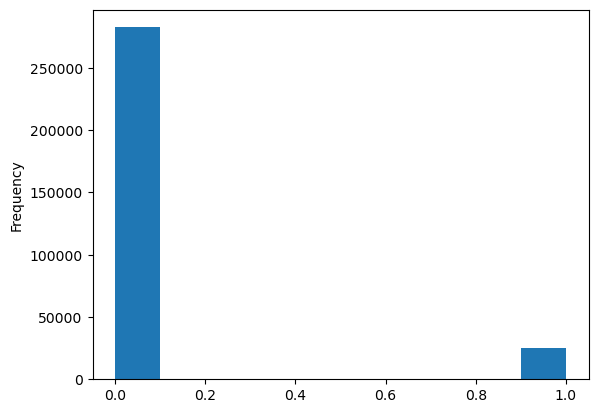

In [37]:
#distribution of target 0 = not default and 1=default
data_in["TARGET"].value_counts(normalize=True) # it shows around 8% are defaulters
data_in["TARGET"].plot(kind='hist')


In [38]:
#Get feature strength
feature_strength = pd.DataFrame([(x, y[0].iv) for x, y in binned_features.items()]).rename(columns={0: "feature", 1: "iv"}).sort_values("iv", ascending=False)
feature_strength.head(10)
# this gives us the strength of the relationship but not the nature of the relationship, it is imp to understand the nature of relationship, then generally, we will use it in the model 

,feature,iv
41,EXT_SOURCE_3,0.335262
40,EXT_SOURCE_2,0.321683
39,EXT_SOURCE_1,0.146393
16,DAYS_EMPLOYED,0.114354
8,AMT_GOODS_PRICE,0.092037
15,DAYS_BIRTH,0.087245
26,OCCUPATION_TYPE,0.079610
38,ORGANIZATION_TYPE,0.071642
6,AMT_CREDIT,0.059368
10,NAME_INCOME_TYPE,0.057869


In [39]:
#Distribution of IV
feature_strength.iv.describe(np.linspace(0,1,11))

count    120.000000
mean       0.027153
std        0.045787
min        0.000000
0%         0.000000
10%        0.000000
20%        0.000666
30%        0.011504
40%        0.013225
50%        0.017755
60%        0.022416
70%        0.028736
80%        0.033208
90%        0.048451
100%       0.335262
max        0.335262
Name: iv, dtype: float64

In [16]:
# a lot of fature have very low IV(<0.05). Generally, we have compute constraints and thus want to remove features which will not add any value to our model. But any feature that has even slight predictive ability should be included in the training process and the model should itself learn how important it is. Since we are not trainnig a linear regression model, we are not overly concerned with colinearily



In [40]:
#Explore individual features using 3 base methods
binned_features['DAYS_BIRTH'][0].build()
# increasing orders of bins means deacreasing order of Age
# event rate = default rate
#conclusion==> with decresing age the default rate increases and logic behind this is as the age increasses the earning capacity of borrower increase and with more income less likely to default

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, -23196.50)",15500,0.050405,14823,677,0.043677,0.653779,1.645258e-02,2.020712e-03
1,"[-23196.50, -20726.50)",41254,0.134155,39035,2219,0.053789,0.434917,2.118060e-02,2.626903e-03
2,"[-20726.50, -19865.50)",16383,0.053276,15440,943,0.057560,0.363165,6.040525e-03,7.509435e-04
3,"[-19865.50, -18796.50)",20818,0.067698,19425,1393,0.066913,0.202616,2.553571e-03,3.186515e-04
4,"[-18796.50, -17367.50)",26196,0.085187,24325,1871,0.071423,0.132546,1.415852e-03,1.768521e-04
5,"[-17367.50, -15327.50)",43050,0.139995,39754,3296,0.076562,0.057515,4.520789e-04,5.650207e-05
6,"[-15327.50, -14654.50)",15754,0.051231,14485,1269,0.080551,0.002399,2.945248e-07,3.681559e-08
7,"[-14654.50, -14017.50)",15395,0.050063,14109,1286,0.083534,-0.037209,7.040428e-05,8.800027e-06
8,"[-14017.50, -13366.50)",15639,0.050857,14241,1398,0.089392,-0.111403,6.613719e-04,8.262876e-05
9,"[-13366.50, -12630.50)",16097,0.052346,14547,1550,0.096291,-0.193356,2.122491e-03,2.648989e-04


In [41]:
#Select number of feature were iv>0.05
selected_features = [feat_name for feat_name, iv in zip(feature_strength["feature"], feature_strength["iv"]) if iv > 0.05]
len(selected_features)


11

In [42]:
data_in[selected_features].dtypes

EXT_SOURCE_3                   float64
EXT_SOURCE_2                   float64
EXT_SOURCE_1                   float64
DAYS_EMPLOYED                    int64
AMT_GOODS_PRICE                float64
DAYS_BIRTH                       int64
OCCUPATION_TYPE                 object
ORGANIZATION_TYPE               object
AMT_CREDIT                     float64
NAME_INCOME_TYPE                object
REGION_RATING_CLIENT_W_CITY      int64
dtype: object

# Model Training 

#Why choose tree models
scale invariant
robut to multi colinearity
robust to outliers
proven to be SOTA for tabular data modelling
lightgbm additionally hnandles categorical variables as well

In [43]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# A parameter grid for LightGBM
params = {
    "min_child_weight": [1, 5, 10],
    "max_depth": [3, 4],
    "learning_rate": [0.001, 0.01, 0.1],
    "colsample_bytree": [0.1, 0.2],
}
clf = lgb.LGBMClassifier(
    verbose_eval=False,
    objective='binary',
    boosting_type='gbdt',
    seed=0,
    verbose=-1,  # Corrected typo "verbosse" to "verbose"
    metric='auc',
    nthread=16,
)

folds = 3

# Always use stratified sampling
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1001)

data_features = data_in[selected_features]  # Corrected variable name "data_features_data_in" to "data_in"
data_target = data_in[target]

for c in data_features.columns:
    if data_features[c].dtype.name == 'object':  # Corrected "data_features(c)" to "data_features[c]"
        data_features[c] = data_features[c].astype('category')

x_train, x_test, y_train, y_test = train_test_split(data_features, data_target, test_size=0.33, random_state=42)

grid_search = GridSearchCV(clf, param_grid=params, scoring='roc_auc', n_jobs=4, cv=skf.split(x_train, y_train),
                           verbose=3)

# here we go
grid_search.fit(x_train, y_train)


Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=<generator object _BaseKFold.split at 0x00000264FE5BDD60>,
             estimator=LGBMClassifier(metric='auc', nthread=16,
                                      objective='binary', seed=0, verbose=-1,
                                      verbose_eval=False),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.1, 0.2],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 4], 'min_child_weight': [1, 5, 10]},
             scoring='roc_auc', verbose=3)

In [44]:
print(grid_search.best_params_,grid_search.best_score_)

{'colsample_bytree': 0.2, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 10} 0.7419860976645097


In [45]:
feature_importance_df=pd.DataFrame()
feature_importance_df["feature"]=selected_features
feature_importance_df["importance"]= grid_search.best_estimator_.feature_importances_

In [46]:
feature_importance_df.sort_values("importance",ascending=False) # this would be different from iv

,feature,importance
4,AMT_GOODS_PRICE,291
8,AMT_CREDIT,202
0,EXT_SOURCE_3,199
6,OCCUPATION_TYPE,183
2,EXT_SOURCE_1,165
1,EXT_SOURCE_2,83
10,REGION_RATING_CLIENT_W_CITY,83
3,DAYS_EMPLOYED,79
7,ORGANIZATION_TYPE,62
5,DAYS_BIRTH,57


#Chosing Right objective 
The RDC AUC is the most popuar measure to judge binary classifiers

In [47]:
from sklearn.metrics import roc_auc_score

classifier = grid_search.best_estimator_
classifier.fit(x_train, y_train)
y_train_probs=classifier.predict_proba(x_train)[:,1]
y_test_probs=classifier.predict_proba(x_test)[:,1]
train_auc=roc_auc_score(y_train,y_train_probs)
test_auc=roc_auc_score(y_test,y_test_probs)
print(f"Model results. Train AUC: {train_auc}.Test AUC: {test_auc}")

Model results. Train AUC: 0.7527438849352787.Test AUC: 0.7432056466058533


In [48]:
import pandas as pd
import numpy as np
def ks(data=None, target=None, prob=None, asc=False):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10, duplicates='raise')
    grouped = data.groupby('bucket', as_index=False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events'] = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable['total'] = grouped.count()['target0']
    kstable['bucket_event_rate'] =kstable.events/kstable.total
    kstable = kstable.sort_values(by="min_prob", ascending=asc).reset_index(drop=True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate'] = (kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3) * 100

    # Formating
    kstable['cum_eventrate'] = kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate'] = kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    # kstable.index = range(1, len(kstable)+1)
    kstable.index = range(1, 11)
    kstable.index.rename('Decile', inplace=True)
    return kstable

In [49]:
test_result_df=pd.DataFrame({"target": y_test,"proba":y_test_probs})
summary_table=ks(test_result_df,"target","proba")
summary_table


,min_prob,max_prob,events,nonevents,total,bucket_event_rate,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,,,
1,0.165369,0.740046,2568,7580,10148,0.253055,31.64%,8.12%,31.64%,8.12%,23.5
2,0.116524,0.165356,1455,8693,10148,0.143378,17.93%,9.31%,49.56%,17.43%,32.1
3,0.090638,0.116522,1112,9036,10148,0.109578,13.70%,9.68%,63.26%,27.11%,36.2
4,0.073162,0.090638,753,9395,10148,0.074202,9.28%,10.06%,72.54%,37.17%,35.4
5,0.059845,0.073162,655,9492,10147,0.064551,8.07%,10.17%,80.61%,47.34%,33.3
6,0.049325,0.059844,490,9658,10148,0.048285,6.04%,10.34%,86.65%,57.68%,29.0
7,0.040503,0.049323,399,9749,10148,0.039318,4.92%,10.44%,91.56%,68.13%,23.4
8,0.032363,0.040503,311,9837,10148,0.030646,3.83%,10.54%,95.39%,78.66%,16.7
9,0.024156,0.032361,231,9917,10148,0.022763,2.85%,10.62%,98.24%,89.28%,9.0


In [46]:
pip install --upgrade numba llvmlite

  Using cached numba-0.57.1-cp39-cp39-win_amd64.whl (2.5 MB)
  Using cached llvmlite-0.40.1-cp39-cp39-win_amd64.whl (27.7 MB)
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.38.0
Note: you may need to restart the kernel to use updated packages.


ERROR: Cannot uninstall 'llvmlite'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [50]:
# Explainibility of in Credit risk models
#Shapley values break down every prediction as sum of contributions of each features

import shap

explainer = shap.TreeExplainer(classifierbooster_)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values[0], x_train)


ImportError: cannot import name 'njit' from 'numba' (unknown location)

In [31]:
obs_idx=780 #Relates to specific observation
shap.decision_plot(np.log(y_train_probs.mean()/(1-y_train_probs.mean())),shap_values[0][obs_idx],x_train.iloc[obs_idx],link='logit', highlight=0)

In [32]:
y_train_probs[780]

Post model deployment 
Data drift: https://deepchecks.com/data-drift-vs-concept-drift-what-are-the-main-difference/
concept drift
model performance check
Reject inferencing: 